In [ ]:
import pandas as pd

# Charger les données
df = pd.read_csv("data/Quality of Service 5G.csv")

# Aperçu rapide
print("Dimensions :", df.shape)
df.head()


✅ Dimensions : (400, 8)


,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation
0,9/3/2023 10:00,User_1,Video_Call,-75 dBm,30 ms,10 Mbps,15 Mbps,70%
1,9/3/2023 10:00,User_2,Voice_Call,-80 dBm,20 ms,100 Kbps,120 Kbps,80%
2,9/3/2023 10:00,User_3,Streaming,-85 dBm,40 ms,5 Mbps,6 Mbps,75%
3,9/3/2023 10:00,User_4,Emergency_Service,-70 dBm,10 ms,1 Mbps,1.5 Mbps,90%
4,9/3/2023 10:00,User_5,Online_Gaming,-78 dBm,25 ms,2 Mbps,3 Mbps,85%


In [7]:
# Conversion de la latence et signal
df["Latency_ms"] = df["Latency"].str.replace(" ms", "").astype(float)
df["Signal_dBm"] = df["Signal_Strength"].str.replace(" dBm", "").astype(float)

# Conversion bande passante en Mbps
def convert_bw(x):
    if "Kbps" in x:
        return float(x.replace(" Kbps", "")) / 1000
    if "Mbps" in x:
        return float(x.replace(" Mbps", ""))
    return 0.0

df["Required_BW_Mbps"] = df["Required_Bandwidth"].apply(convert_bw)
df["Allocated_BW_Mbps"] = df["Allocated_Bandwidth"].apply(convert_bw)


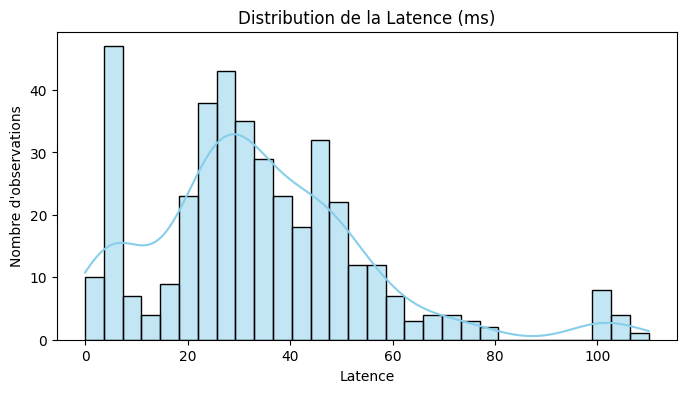

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df["Latency_ms"], bins=30, kde=True, color="skyblue")
plt.title("Distribution de la Latence (ms)")
plt.xlabel("Latence")
plt.ylabel("Nombre d'observations")
plt.show()


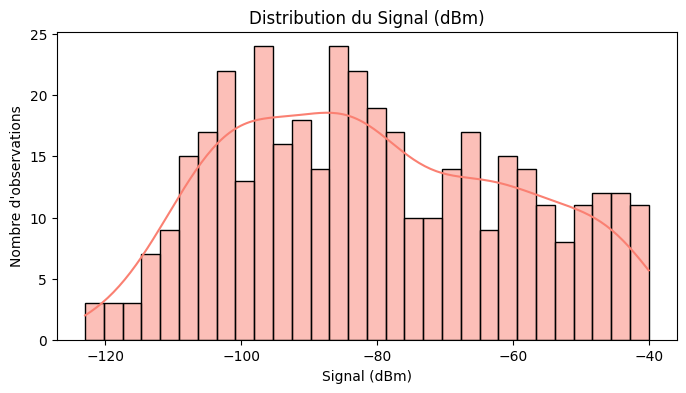

In [9]:
plt.figure(figsize=(8, 4))
sns.histplot(df["Signal_dBm"], bins=30, kde=True, color="salmon")
plt.title("Distribution du Signal (dBm)")
plt.xlabel("Signal (dBm)")
plt.ylabel("Nombre d'observations")
plt.show()


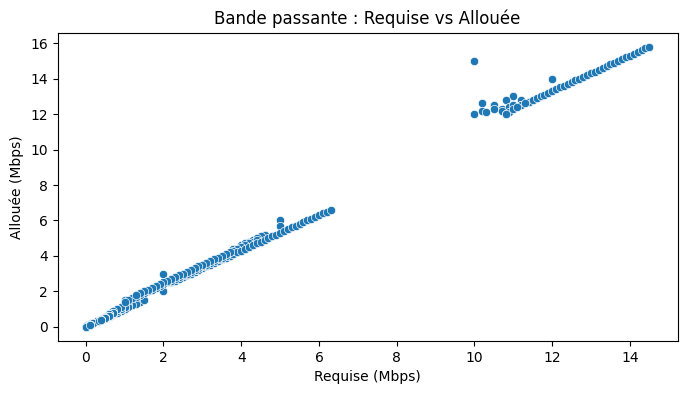

In [10]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x="Required_BW_Mbps", y="Allocated_BW_Mbps", data=df)
plt.title("Bande passante : Requise vs Allouée")
plt.xlabel("Requise (Mbps)")
plt.ylabel("Allouée (Mbps)")
plt.show()


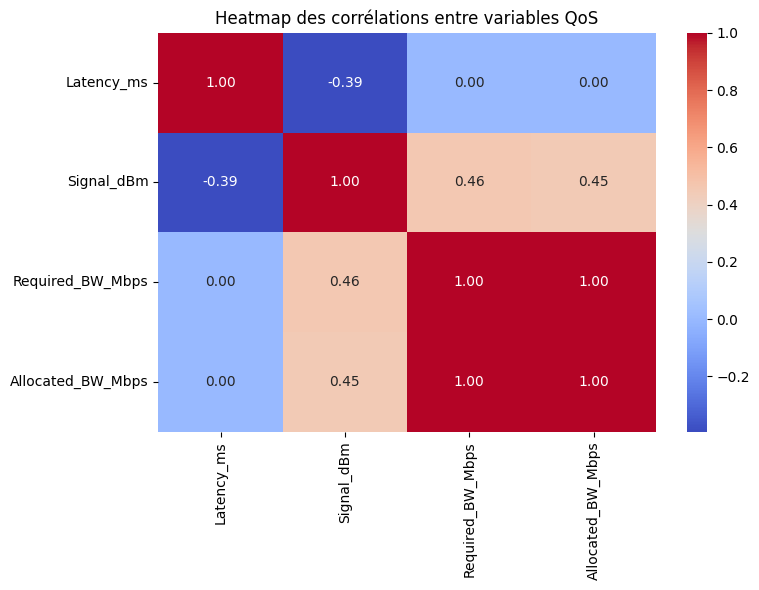

In [12]:
# Sélection des variables numériques à corréler
cols_qos = ["Latency_ms", "Signal_dBm", "Required_BW_Mbps", "Allocated_BW_Mbps"]
correlation_matrix = df[cols_qos].corr()

# Affichage de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap des corrélations entre variables QoS")
plt.tight_layout()
plt.savefig("graphs/correlation_heatmap.png")
plt.show()


In [13]:
# Seuils simples d'anomalies
seuil_latence = 100         # > 100 ms = trop lent
seuil_signal = -90          # < -90 dBm = très mauvais signal
df["Anomalie_Latence"] = df["Latency_ms"] > seuil_latence
df["Anomalie_Signal"] = df["Signal_dBm"] < seuil_signal
df["Anomalie_BW"] = df["Allocated_BW_Mbps"] < df["Required_BW_Mbps"]

# Création d'une colonne générale : est-ce qu'au moins UNE anomalie ?
df["Anomalie_Global"] = df[["Anomalie_Latence", "Anomalie_Signal", "Anomalie_BW"]].any(axis=1)

# Résumé
print("Anomalies détectées :")
print(df[["Anomalie_Latence", "Anomalie_Signal", "Anomalie_BW", "Anomalie_Global"]].sum())


Anomalies détectées :
Anomalie_Latence      7
Anomalie_Signal     143
Anomalie_BW           0
Anomalie_Global     143
dtype: int64


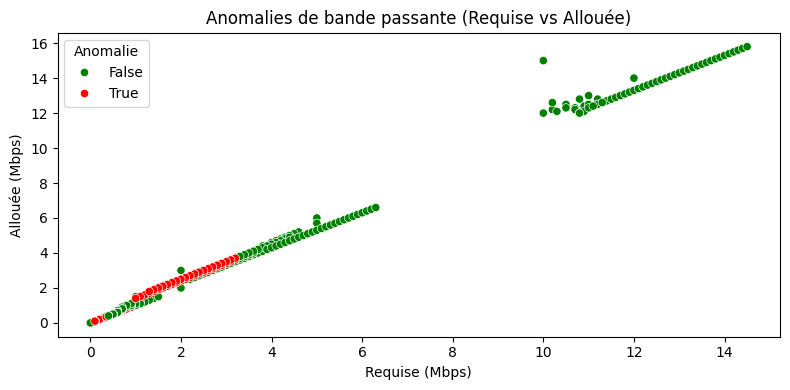

In [15]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x="Required_BW_Mbps", y="Allocated_BW_Mbps", hue="Anomalie_Global", data=df, palette=["green", "red"])
plt.title("Anomalies de bande passante (Requise vs Allouée)")
plt.xlabel("Requise (Mbps)")
plt.ylabel("Allouée (Mbps)")
plt.legend(title="Anomalie")
plt.tight_layout()
plt.savefig("graphs/anomalie_bw.png")
plt.show()


C:\Users\ndeye\AppData\Local\Temp\ipykernel_19924\2256930418.py:3: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(


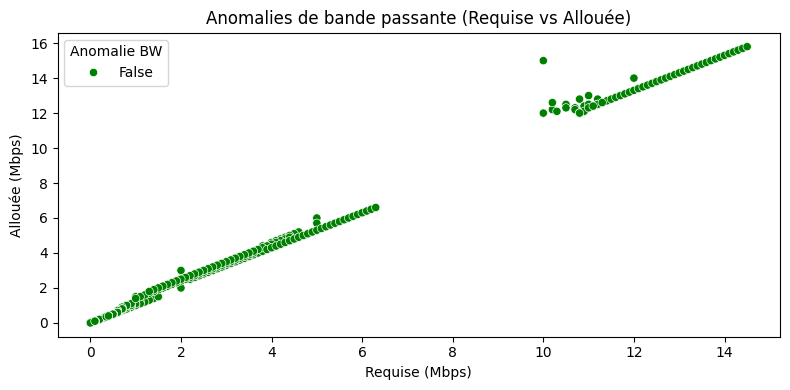

In [17]:
#Anomalie de bande passante
plt.figure(figsize=(8, 4))
sns.scatterplot(
    x="Required_BW_Mbps", 
    y="Allocated_BW_Mbps", 
    hue="Anomalie_BW", 
    data=df, 
    palette=["green", "red"]
)
plt.title("Anomalies de bande passante (Requise vs Allouée)")
plt.xlabel("Requise (Mbps)")
plt.ylabel("Allouée (Mbps)")
plt.legend(title="Anomalie BW")
plt.tight_layout()
plt.savefig("graphs/anomalie_bw_seule.png")
plt.show()


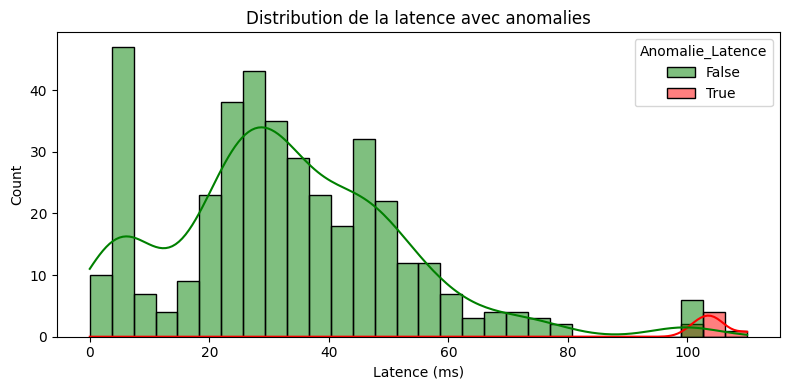

In [18]:
#Anomalie de latence
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="Latency_ms", hue="Anomalie_Latence", bins=30, kde=True, palette=["green", "red"])
plt.title("Distribution de la latence avec anomalies")
plt.xlabel("Latence (ms)")
plt.tight_layout()
plt.savefig("graphs/anomalie_latence.png")
plt.show()


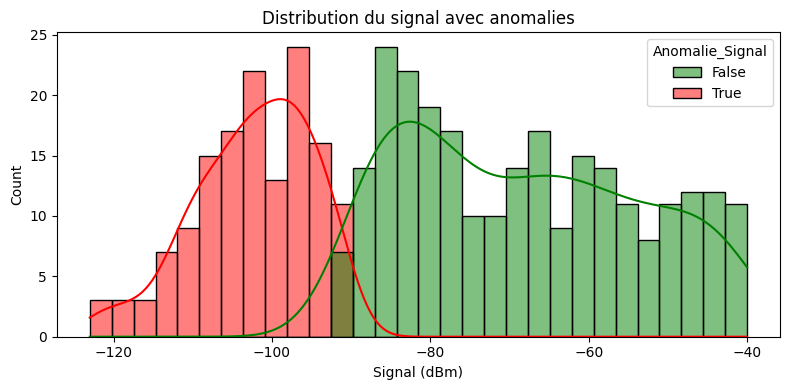

In [19]:
#Anomalie de signal
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="Signal_dBm", hue="Anomalie_Signal", bins=30, kde=True, palette=["green", "red"])
plt.title("Distribution du signal avec anomalies")
plt.xlabel("Signal (dBm)")
plt.tight_layout()
plt.savefig("graphs/anomalie_signal.png")
plt.show()


In [ ]:
df_anomalies = df[df["Anomalie_Global"] == True]
df_anomalies.to_csv("reports/anomalies_detectees.csv", index=False)
print("📁 Anomalies enregistrées dans 'reports/anomalies_detectees.csv'")
